# 1) The Dissipative Pendulum

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('notebook.mplstyle');
%config InlineBackend.figure_format = 'svg'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from scipy.constants import pi as π
from scipy.constants import g

Text(0, 0.5, 'θ(t) [rad]')

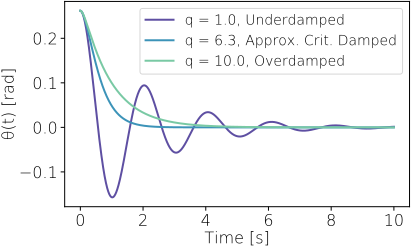

In [4]:
def euler_cromer_method(t, q):
    ℓ = 1 # m
    θ,ω = np.zeros_like(t),np.zeros_like(t)
    θ[0] = π/12.0 # rad
    for n in range(t.size-1):
        ω[n+1] = ω[n] +(-(g/ℓ)*np.sin(θ[n])-q*ω[n]) *Δt
        θ[n+1] = θ[n] + ω[n+1]*Δt
    return ω, θ

Δt = 0.001 # s
t = np.arange(0.0,10.0,Δt)
# solve for critically damped
for i, qn in enumerate(np.arange(1,10,.1)):
    ω, θ = euler_cromer_method(t,qn)
    if (θ > 0).all():
        cdamp=qn
        break
q = [1, cdamp, 10]
    
dampness =['Underdamped', 'Approx. Crit. Damped', 'Overdamped']
for i, qn in enumerate(q):
    ω, θ = euler_cromer_method(t, qn)
    plt.plot(t,θ, label=f'q = {qn:.1f}, {dampness[i]}')
plt.legend(loc='best',frameon=True)

plt.xlabel('Time [s]')
plt.ylabel('θ(t) [rad]')

### Derivation of Critically Damped
The equation of motion of the dissipative pendulum can be found below:

\begin{equation}
\ddot{\theta}=\frac{-g}{\ell}\sin\theta-\gamma\dot{\theta}
\end{equation}

For small angles (where the pundulum is operating in the linear region) the solution to the differential equation is exponential ($\theta = e^{rt}$ ), so:

\begin{equation}
r^2=\frac{-g}{\ell}-\gamma r
\end{equation}

Since this is a quadratic equation, we can easily find the roots
\begin{equation}
r^2+\gamma r+\frac{g}{\ell} = 0
\end{equation}

We know that $\frac{g}{\ell} = \omega_0^2$

\begin{equation}
r^2+\gamma r+\omega_0^2 = 0
\end{equation}

Now we solve the quadratic equation:

\begin{equation}
r = \frac{-\gamma \pm \sqrt{\gamma^2-4\omega_0^2}}{2}
\end{equation}

Which yeilds: 

\begin{equation}
\gamma^2 = 4\omega_0^2
\end{equation}

 

In [5]:
ω, θ = euler_cromer_method(t, 6.2)
ℓ = 1
# Lets just check if this holds
print(f'Calculated \u03C90 = {np.sqrt(4*g/ℓ)}')


Calculated ω0 = 6.2631142413339385


# 2) Chaos and Lyapunov Exponent

In [7]:
from scipy.constants import g
from scipy.constants import pi as π
def euler(t,FD,ℓ,θ0,ω0,γ,ΩD):
    ''' Semi-implicit Euler Method for the non-linear, dissipative, driven pendulum.'''
    
    Δt = t[1]-t[0]
    ω,θ = np.zeros_like(t),np.zeros_like(t)
    θ[0],ω[0] = θ0,ω0
    
    # perform the numerical integration
    for n in range(t.size-1):
        ω[n+1] = ω[n] + (-(g/ℓ)*np.sin(θ[n]) - γ*ω[n] + FD*np.sin(ΩD*t[n]))*Δt
        θ[n+1] = θ[n] + ω[n+1]*Δt
        
        # keep theta in [-pi,pi)
        if θ[n+1] < -π: θ[n+1] += 2.0*π
        if θ[n+1] >= π: θ[n+1] -= 2.0*π 

    return θ,ω

Text(0.5, 0, 'Time [s]')

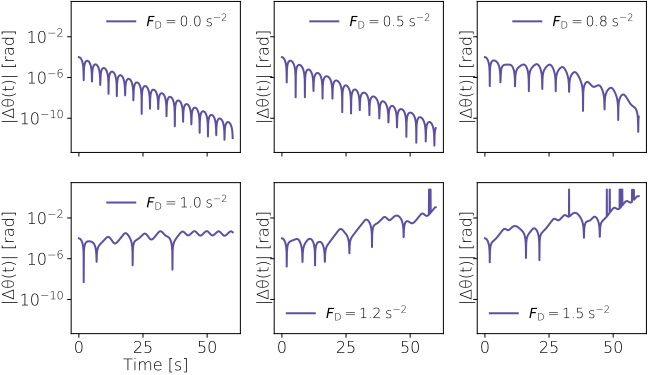

In [8]:
params = ℓ,θ0,ω0,γ,ΩD = g, 0.2, 0.0, 0.5, 2.0/3.0
FD = [0.0,0.5,0.75,1.0,1.25,1.5]
Δt = 0.04
t = np.arange(0.0,60,Δt)

F = [0.0,0.5,0.8,1.0,1.2,1.5] # driving force [1/s^2]
θ0 = 0.2 # initial angle [rad]
params = [(ℓ,θ0,ω0,γ,ΩD),(ℓ,θ0+1.0E-4,ω0,γ,ΩD)]

Δθ = []
fig, axes = plt.subplots(2,3,sharex=True, sharey=True, squeeze=False, figsize=(10,6))
for i, ax in enumerate(axes.flat):
    label = r'$F_\mathrm{D} = %3.1f\; \mathrm{s}^{-2}$' % F[i]
    
    θ1,ω = euler(t,F[i],*params[0])
    θ2,ω = euler(t,F[i],*params[1])
    Δθ.append(np.abs(θ1-θ2))
    
    ax.semilogy(t, Δθ[i], label=label)
    ax.legend(loc='best', frameon=False)
    
    # set axis labels
    ax.set_ylabel('|Δθ(t)| [rad]')

axes[1,0].set_xlabel('Time [s]')

Text(0.5, 0, 'Time [s]')

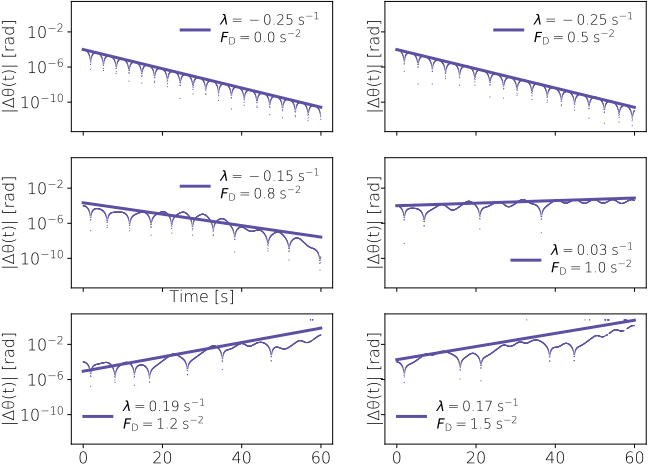

In [9]:
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
F = [0.0,0.5,0.8,1.0,1.2,1.5]
# Linear fitting function
def linear(x,a0,a1):
    return a0 + a1*x

# find the local maxima and perform the fit
popt = [0,0,0,0,0,0]
for i,cF in enumerate(F):
    ind = argrelextrema(np.log(Δθ[i]),np.greater)[0]
    popt[i], pcov = curve_fit(linear,t[ind],np.log(Δθ[i][ind]))

fig, axes = plt.subplots(3,2,sharex=True, sharey=True, squeeze=False, figsize=(10,8))
for i, ax in enumerate(axes.flat):
    labellam = r'$\lambda = %4.2f\; \mathrm{s}^{-1}$' % popt[i][1] + \
        '\n$F_\mathrm{D} = %3.1f\; \mathrm{s}^{-2}$' % F[i]
    
    ax.semilogy(t, Δθ[i], ',', markeredgewidth=0.0)
    ax.semilogy(t, np.exp(linear(t,*popt[i])), linewidth=3.0, label=labellam, color=colors[0])
      
    # set labels and legend
    ax.set_ylabel('|Δθ(t)| [rad]')
#     ax.text(30,0,r'$F_\mathrm{D} = %3.1f\; \mathrm{s}^{-2}$' % F[i],fontsize=15)
    ax.legend()
axes[1,0].set_xlabel('Time [s]')
# dont plot every time,  just 

## Graduate Credit

Text(0.5, 1.0, 'Driving Force vs. Lyapunov Exponent')

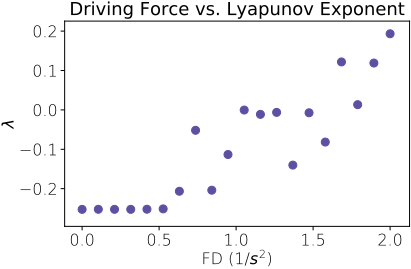

In [11]:
Δt = 0.04
t = np.arange(0.0,60,Δt)

F = np.linspace(0,2,20) # driving force [1/s^2]
θ0 = 0.2 # initial angle [rad]
params = [(ℓ,θ0,ω0,γ,ΩD),(ℓ,θ0+1.0E-4,ω0,γ,ΩD)]

Δθ = []
# fig, axes = plt.subplots(2,3,sharex=True, sharey=True, squeeze=False, figsize=(10,6))
for i, ax in enumerate(F):
    label = r'$F_\mathrm{D} = %3.1f\; \mathrm{s}^{-2}$' % F[i]
    
    θ1,ω = euler(t,F[i],*params[0])
    θ2,ω = euler(t,F[i],*params[1])
    Δθ.append(np.abs(θ1-θ2))

def linear(x,a0,a1):
    return a0 + a1*x

# find the local maxima and perform the fit
popt = np.zeros_like(F).tolist()
# From class
for i,cF in enumerate(F):
    ind = argrelextrema(np.log(Δθ[i]),np.greater)[0]
    popt[i], pcov = curve_fit(linear,t[ind],np.log(Δθ[i][ind]))
for i,Fi in enumerate(F): # plot all Fd vs lyapunov exponent
    plt.scatter(Fi, popt[i][1], color=colors[0])
plt.xlabel('FD (1/$s^2$)')
plt.ylabel('$\lambda$')
plt.title('Driving Force vs. Lyapunov Exponent')

# 3) The Logistic Map

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [18]:
# From Class
def logistic_map(x,μ):
    '''Return the iterative logistic map.'''
    for ii in range(len(x)-1):
        x[ii+1] = μ*x[ii]*(1-x[ii])

    # INSERT CODE HERE
    return x

def μ_lab(μ):
    return f'$\mu =  {μ:G}$'

In [19]:
# Create points for bifurcation diagram
num_μ = 500
μ = np.linspace(1,4,num_μ)
x = np.zeros([1200, num_μ])

for i,cμ in enumerate(μ):
    x[0,i] = np.random.random()
    x[:,i] = logistic_map(x[:,i], μ[i])

Text(0.5, 1.0, 'Bifurcation Diagram')

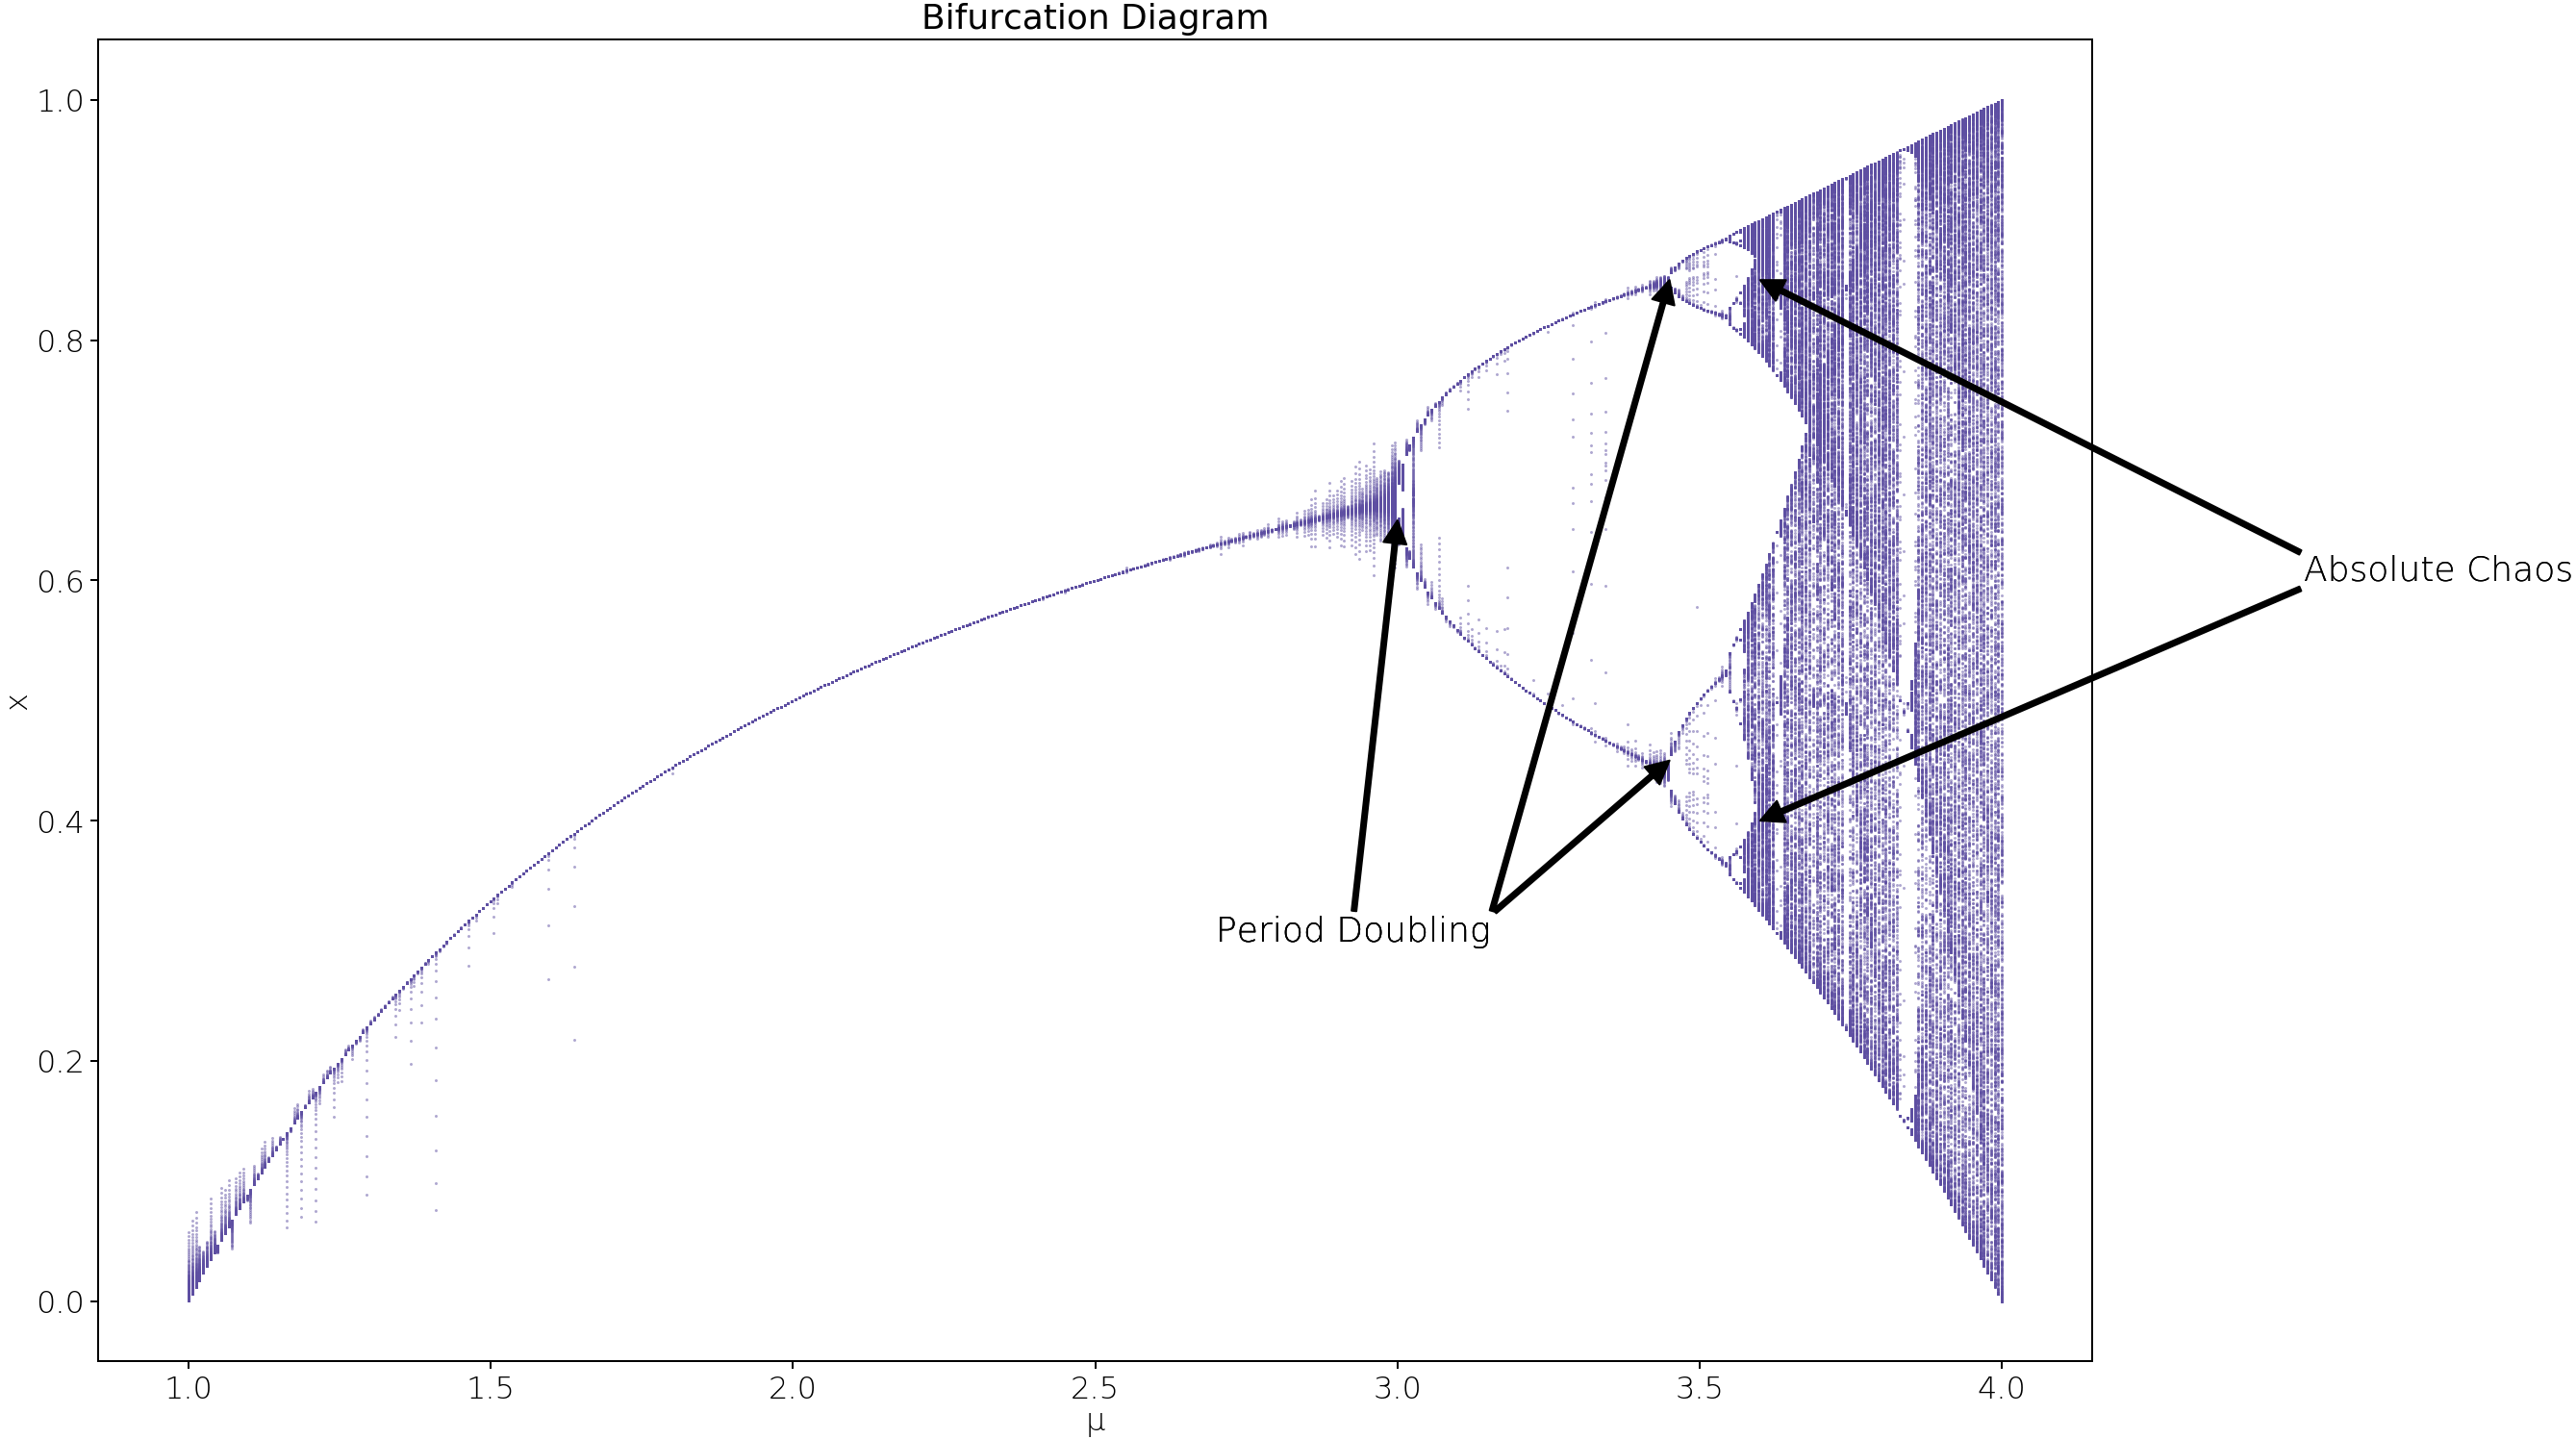

In [35]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)

for i,cμ in enumerate(μ):
    pt_x = x[10:, i] # Remove transients
    pt_μ = cμ*np.ones_like(pt_x)
    plt.plot(pt_μ,pt_x,'.', markersize=1, alpha=0.5, color=colors[0])
# Coords for annotation
coords = [(3,0.65), (3.45,0.45), (3.45,0.85) , (3.6,0.85), (3.6,0.4)]

for ii,c in enumerate(coords):
    if ii < 3:
        text = 'Period Doubling'
        txt_coords = (2.7, 0.3)
    else:
        text = 'Absolute Chaos'
        txt_coords = (4.5, 0.6)
        
    ax.annotate(text, xy=c, xytext=txt_coords, fontsize = 18,
                arrowprops=dict(facecolor='black', width = 2.5))
plt.xlabel('μ')
plt.ylabel('x')
plt.title('Bifurcation Diagram')

# 4) Final Project
The Fast Fourier Transform (FFT), has numerous applications in physics, engineering, and mathematics.  Specifcally in radio astronomy, very large FFTs are often required due to the sheer amounts of incoming data.  Computing the FFT can be quite expensive on a traditional CPU, so graphics processing units (GPUs) offer a significant performance increase due to their numerous cores.  Other devices can be used (such as FPGAs) but we have access to several GPUs through DeepGreen on the VACC. This project would aim to create a FFT program capable of performing different size FFTs for radio signal processing.

There is an open source package called pyCUDA, allowing for cuda programming in python.  This will speed up the development time of the FFT program compared to writing cuda code. PyFFT is another open source package that uses pyCUDA, allowing the GPUs to perform FFTs.
https://mc.stanford.edu/cgi-bin/images/7/75/SC08_FFT_on_GPUs.pdf
https://www.nrao.edu/meetings/isstt/papers/2009/2009199201.pdf
https://pypi.org/project/pyfft/0.3.1/
https://developer.nvidia.com/pycuda